In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

# Налаштування TensorFlow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Визначення шляхів для завантаження ресурсів
models_file_path = './models/'
file_model = 'ua-license-plate-recognition-model-37x.h5'
file_cascad = 'haarcascade_russian_plate_number.xml'
full_path_models = os.path.join(models_file_path, file_model)  
full_path_cascad = os.path.join(models_file_path, file_cascad)

# Завантаження моделі та каскадного класифікатора
model = load_model(full_path_models)
plate_cascade = cv2.CascadeClassifier(full_path_cascad)

img_file_path = './img/'
file_img = 'AM0074BB.png'
full_path_img = os.path.join(img_file_path, file_img)


ImportError: attempted relative import with no known parent package

In [157]:
def detect_plate(img, text=''): 
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) 
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] 
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) 
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate 

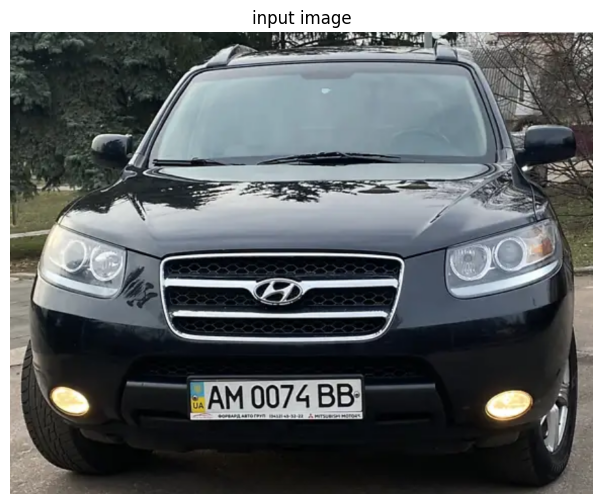

In [171]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread(f'{full_path_img}')
display(img, 'input image')

In [159]:
output_img, plate = detect_plate(img)

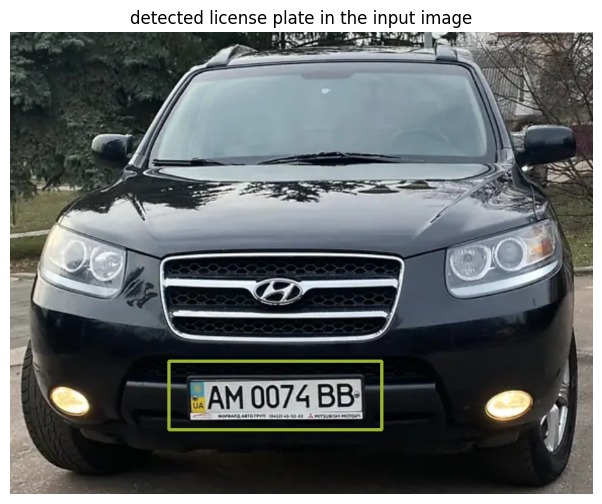

In [160]:
display(output_img, 'detected license plate in the input image')

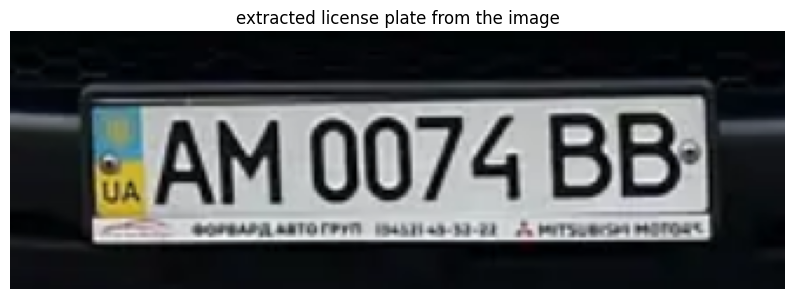

In [161]:
display(plate, 'extracted license plate from the image')

In [162]:
def resize_img(img, target_height=720):
    height, width = img.shape[:2]
    if height <= target_height:
        return img
    target_width = int(width * (target_height / height))
    resized_img = cv2.resize(img, (target_width, target_height))
    return resized_img



In [163]:
def extract_plate(img, plate_cascade, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plate = None
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.05, minNeighbors=8)

    width_max = 0
    plate_max = None
    x_max = 0
    y_max = 0

    for (x, y, w, h) in plate_rect:
        a, b = (int(0.1 * h), int(0.1 * w))
        aa, bb = (int(0.1 * h), int(0.1 * w))

        if h > 75:
            b = 0
            bb = 0

        plate = roi[y + a: y + h - aa, x + b: x + w - bb, :]

        if width_max < w:
            plate_max = plate
            width_max = w
            x_max = x
            y_max = y

        cv2.rectangle(plate_img, (x + 2, y), (x + w - 3, y + h - 5), (51, 224, 172), 3)

    if text != '':
        h = plate_max.shape[0]
        plate_img = cv2.putText(plate_img, text, (x_max, y_max - h // 3), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5, (51, 224, 172), 2, cv2.LINE_AA)
        
    return plate_img, plate_max


In [164]:
def find_contours(dimensions, img):
    i_width_threshold = 6
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width, upper_width, lower_height, upper_height = dimensions

    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:16]
    
    ii = np.dstack([img] * 3)
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        if (intWidth >= i_width_threshold and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height):
            x_cntr_list.append(intX)

            char_copy = np.zeros((44, 24))
            char = img[intY:intY + intHeight, intX:intX + intWidth]

            if (intWidth >= i_width_threshold and intWidth < lower_width):
                i_char = cv2.resize(char, (intWidth, 42), interpolation=cv2.INTER_LINEAR_EXACT)

                char = np.full((42, 22), 255, dtype=np.uint8)
                begin = int((22 - intWidth) / 2)
                char[:, begin:begin + intWidth] = i_char[:, :]
            else:
                char = cv2.resize(char, (22, 42), interpolation=cv2.INTER_LINEAR_EXACT)
            
            cv2.rectangle(ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2)

            char = cv2.subtract(255, char)

            char_copy[1:43, 1:23] = char
            char_copy[0:1, :] = 0
            char_copy[:, 0:1] = 0
            char_copy[43:44, :] = 0
            char_copy[:, 23:24] = 0

            img_res.append(char_copy)
            if len(img_res) >= 10: break
            
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = [img_res[idx] for idx in indices]
    img_res = np.array(img_res_copy)

    return img_res


In [165]:
def segment_to_contours(image):
    new_height = 75
    img_lp = cv2.resize(image, (333, new_height), interpolation=cv2.INTER_LINEAR_EXACT)
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 112, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    LP_WIDTH = img_binary_lp.shape[1]
    LP_HEIGHT = img_binary_lp.shape[0]

    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[new_height - 3:new_height, :] = 255
    img_binary_lp[:, 330:333] = 255

    dimensions = [LP_WIDTH / 24,
                LP_WIDTH / 8,
                LP_HEIGHT / 3,
                2 * LP_HEIGHT / 3]
    
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()

    char_list = find_contours(dimensions, img_binary_lp)
    return char_list


In [166]:
# char = segment_to_contours(plate)

In [167]:
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img


In [168]:
def predict_result(ch_contours, model):
    dic = {i: c for i, c in enumerate('#0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')}
    output = []

    for ch in ch_contours:
        img_ = cv2.resize(ch, (28, 28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)
        y_ = np.argmax(model.predict(img, verbose=0), axis=-1)[0]
        character = dic[y_]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number


In [169]:
def get_num_avto(img_avto):
    img = img_avto.copy()
    output_img, num_img = extract_plate(img, plate_cascade)
    chars = segment_to_contours(num_img)
    predicted_str = predict_result(chars, model)
    num_avto_str = predicted_str.replace('#', '')
    return num_avto_str, num_img


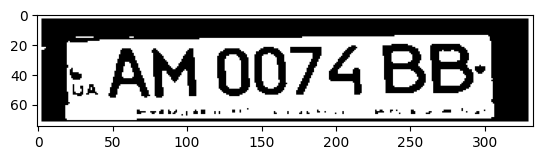

Номер - AM0074BB


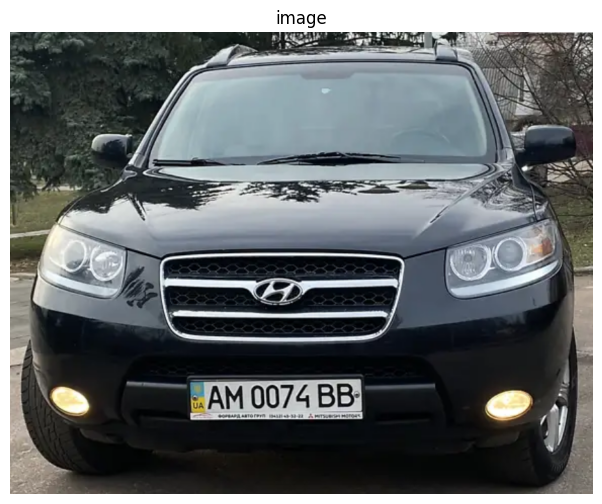

In [170]:
if __name__ == '__main__':
    original = cv2.imread(full_path_img)
    if original is None:
        print("Помилка завантаження зображення. Перевірте шлях до файлу.")
        exit(1)

    result = get_num_avto(original)
    print(f'Номер - {result[0]}')
    display(img, 'image')


In [2]:
import io
import cv2
import os
import base64
import numpy as np
from keras import saving
from pathlib import Path

class PlateRecognition:

    def __init__(self):
        # Визначення шляхів для завантаження ресурсів
        self.models_file_path = Path('plate_recognition/models/')
        self.file_model = 'ua-license-plate-recognition-model-37x.h5'
        self.file_cascade = 'haarcascade_russian_plate_number.xml'
        self.full_path_models = os.path.join(self.models_file_path, self.file_model)
        self.full_path_cascade = os.path.join(self.models_file_path, self.file_cascade)

        # Завантаження моделі та каскадного класифікатора
        self.load_model()

    def load_model(self):
        # Завантаження моделі та каскадного класифікатора
        try:
            self.model = saving.load_model(self.full_path_models)
            self.plate_cascade = cv2.CascadeClassifier(self.full_path_cascade)
            self.model_load_status = True
        except Exception as e:
            print(f"Error loading model or classifier: {e}")
            self.model_load_status = None

    def predict_plate(self, file_path):
        # Читання зображення з файлу
        file_image = open(file_path, 'rb').read()

        uploaded_image = self.decode_io_file(file_image)

        output_image, num_image = self.extract_plate(uploaded_image)

        if num_image is not None:
            chars = self.segment_to_contours(num_image)
            predicted_str, total_accuracy = self.predict_result(chars, self.model)
            num_vehicle_str = predicted_str.replace("#", "")

            num_result = {
                "num_vehicle_str": num_vehicle_str,
                "accuracy": total_accuracy,
                "num_img": num_image,
            }
        else:
            num_result = {}

        img = num_result.get('num_img', None)
        is_success = img is not None

        if is_success:
            try:
                is_success, im_buf_arr = cv2.imencode(
                    ".png", img, params=[cv2.IMWRITE_PNG_COMPRESSION, 5]
                )
            except Exception as e:
                print(f"Error encoding image: {e}")
                is_success = False

        if is_success:
            io_buf = io.BytesIO(im_buf_arr)
            image = self.build_base64_image(io_buf.getvalue())
            num_result["num_img"] = image
            im_buf_arr = np.zeros(0)

            if not num_result["num_vehicle_str"]:
                num_result["accuracy"] = 0
            elif len(num_result["num_vehicle_str"]) < 6:
                num_result["accuracy"] *= 0.3

        else:
            num_result["num_img"] = None
            num_result["accuracy"] = 0
            print("num_result[num_img] = None")

        return num_result

    def decode_io_file(self, f):
        io_buf = io.BytesIO(f)
        image_array = np.frombuffer(io_buf.getbuffer(), np.uint8)
        decode_img = cv2.imdecode(image_array, cv2.IMREAD_UNCHANGED)
        return decode_img

    def extract_plate(self, image, text=""):
        plate_image = image.copy()
        roi = image.copy()
        plate = None
        plate_rect = self.plate_cascade.detectMultiScale(plate_image, scaleFactor=1.05, minNeighbors=8)

        width_max = 0
        plate_max = None
        x_max = 0
        y_max = 0

        for (x, y, w, h) in plate_rect:
            a, b = (int(0.1 * h), int(0.1 * w))
            aa, bb = (int(0.1 * h), int(0.1 * w))

            if h > 75:
                b = 0
                bb = 0

            plate = roi[y+a : y+h-aa, x+b : x+w-bb, :]

            if width_max < w:
                plate_max = plate
                width_max = w
                x_max = x
                y_max = y

            cv2.rectangle(plate_image, (x+2,y), (x+w-3, y+h-5), (51,224,172), 3)
        if text != '':
            h = plate_max.shape[0]
            plate_image = cv2.putText(plate_image, text, (x_max, y_max-h//3),
                                    cv2.FONT_HERSHEY_COMPLEX_SMALL , 1.5, (51,224,172), 2, cv2.LINE_AA)

        return plate_image, plate_max

    def segment_to_contours(self, image, debug: bool = False):
        new_height = 75
        img_lp = cv2.resize(image, (333, new_height), interpolation=cv2.INTER_LINEAR_EXACT)

        img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
        _, img_binary_lp = cv2.threshold(
            img_gray_lp, 112, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

        LP_WIDTH = img_binary_lp.shape[1]
        LP_HEIGHT = img_binary_lp.shape[0]

        img_binary_lp[0:3, :] = 255
        img_binary_lp[:, 0:3] = 255
        img_binary_lp[new_height - 3 : new_height, :] = 255
        img_binary_lp[:, 330:333] = 255

        dimensions = [LP_WIDTH / 24, LP_WIDTH / 8, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
        char_list = self.find_contours(dimensions, img_binary_lp)
        return char_list

    def find_contours(self, dimensions, img, debug=False):
        i_width_threshold = 6
        cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        lower_width = dimensions[0]
        upper_width = dimensions[1]
        lower_height = dimensions[2]
        upper_height = dimensions[3]

        cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:16]

        ii = np.dstack([img] * 3)

        x_cntr_list = []
        target_contours = []
        img_res = []
        for cntr in cntrs:
            intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

            if (
                intWidth >= i_width_threshold
                and intWidth < upper_width
                and intHeight > lower_height
                and intHeight < upper_height
            ):
                x_cntr_list.append(intX)

                char_copy = np.zeros((44, 24))
                char = img[intY : intY + intHeight, intX : intX + intWidth]

                if intWidth >= i_width_threshold and intWidth < lower_width:
                    i_char = cv2.resize(
                        char, (intWidth, 42), interpolation=cv2.INTER_LINEAR_EXACT
                    )

                    char = np.full((42, 22), 255, dtype=np.uint8)
                    begin = int((22 - intWidth) / 2)
                    char[:, begin : begin + intWidth] = i_char[:, :]
                else:
                    char = cv2.resize(char, (22, 42), interpolation=cv2.INTER_LINEAR_EXACT)

                cv2.rectangle(
                    ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2
                )

                char = cv2.subtract(255, char)

                char_copy[1:43, 1:23] = char
                char_copy[0:1, :] = 0
                char_copy[:, 0:1] = 0
                char_copy[43:44, :] = 0
                char_copy[:, 23:24] = 0

                img_res.append(char_copy)
                if len(img_res) >= 10:
                    break

        indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
        img_res_copy = []
        for idx in indices:
            img_res_copy.append(img_res[idx])
        img_res = np.array(img_res_copy)

        return img_res

    def predict_result(self, ch_contours, model):
        dic = {}
        characters = "#0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        for i, c in enumerate(characters):
            dic[i] = c

        total_accuracy = 1.0

        output = []
        for i, ch in enumerate(ch_contours):
            img_ = cv2.resize(ch, (28, 28))

            img = self.fix_dimension(img_)
            img = img.reshape(1, 28, 28, 3)

            prediction = model.predict(img, verbose=0)

            y_ = np.argmax(prediction, axis=-1)[0]

            character = dic[y_]

            output.append(character)

        plate_number = "".join(output)
        return plate_number, total_accuracy

    def fix_dimension(self, img):
        new_img = np.zeros((28, 28, 3))
        for i in range(3):
            new_img[:, :, i] = img
        return new_img

    def build_base64_image(self, binary_image_data):
        return base64.b64encode(binary_image_data).decode("utf-8")

if __name__ == "__main__":
    plate_recognition = PlateRecognition()

    # Вкажіть шлях до вашого зображення
    image_path = 'img/AI1182HK.jpg'

    result = plate_recognition.predict_plate(image_path)

    print("Номерний знак:", result.get("num_vehicle_str", "Не вдалося розпізнати"))
    print("Точність:", result.get("accuracy"))

    num_img = result.get("num_img")
    if num_img:
        with open('output_image.png', 'wb') as f:
            f.write(base64.b64decode(num_img))


Error loading model or classifier: [Errno 2] Unable to synchronously open file (unable to open file: name = 'plate_recognition\models\ua-license-plate-recognition-model-37x.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


AttributeError: 'PlateRecognition' object has no attribute 'plate_cascade'

In [6]:
import cv2

# Перевірте шлях до вашого каскадного класифікатора
full_path_cascade = 'plate_recognition/models/haarcascade_russian_plate_number.xml'
plate_cascade = cv2.CascadeClassifier(full_path_cascade)

if plate_cascade.empty():
    print("Failed to load cascade classifier.")
else:
    print("Cascade classifier loaded successfully.")


Failed to load cascade classifier.
